# M5 Forecasting - Accuracy: Custom Solution

**Course:** Light Auto ML  
**Task:** Kaggle M5 Competition - Walmart Sales Forecasting  
**Part 3:** Custom Solution Beyond LAMA Baseline

## Overview

This notebook implements a custom pipeline to beat the LAMA baseline:
- **Advanced Feature Engineering**: More sophisticated features beyond basic lags
- **Custom Pipeline**: Using scikit-learn Pipeline for reproducibility
- **Multiple Model Attempts**: Different algorithms and hyperparameter settings
- **Hyperparameter Optimization**: Grid search and random search
- **Ensemble Methods**: Combining predictions from multiple models

# ## 1. Настройка окружения и загрузка данных

In [ ]:
!pip uninstall -y lightgbm



Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


In [1]:
pip install lightgbm --config-settings=cmake.define.USE_CUDA=ON

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
import joblib
import gc
warnings.filterwarnings('ignore')

# ML imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"Start time: {datetime.now()}")

# DATA_PATH = Path('../input/m5-forecasting-accuracy')
OUTPUT_PATH = Path('./models')
OUTPUT_PATH.mkdir(exist_ok=True)

print("Loading data...")
sales_train = pd.read_csv('sales_train_evaluation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

print(f"Data loaded successfully")

Start time: 2025-12-20 23:20:49.469791
Loading data...
Data loaded successfully


# ## 2. Продвинутая генерация признаков

In [5]:
def prepare_advanced_features_fast(sales_train, calendar, prices, sample_products=100):
    # -------- 0) Sampling (как у тебя) --------
    if sample_products:
        np.random.seed(42)
        products = np.random.choice(sales_train['item_id'].unique(), sample_products, replace=False)
        sales_train = sales_train[sales_train['item_id'].isin(products)].copy()

    id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    date_cols = [c for c in sales_train.columns if c.startswith('d_')]

    # Приведем ключи к category (часто ускоряет merge/groupby на повторяющихся строковых ключах)
    for c in ['item_id', 'store_id', 'state_id', 'dept_id', 'cat_id']:
        if c in sales_train.columns and sales_train[c].dtype != 'category':
            sales_train[c] = sales_train[c].astype('category')

    # -------- 1) Wide -> long быстрее через stack, чем melt на больших таблицах --------
    # (melt делает больше аллокаций; stack часто быстрее для "d_1..d_N" формата) [web:41][web:39]
    tmp = sales_train.set_index(id_cols)[date_cols]
    sales_long = (tmp
                  .stack(dropna=False)
                  .rename('sales')
                  .reset_index()
                  .rename(columns={'level_6': 'day'}))  # level_6 зависит от числа id_cols; см. ниже примечание

    # Если pandas назвал последний уровень иначе (например, 'level_6'), оставим универсально:
    if 'day' not in sales_long.columns:
        # последний столбец после reset_index — это day
        sales_long = sales_long.rename(columns={sales_long.columns[len(id_cols)]: 'day'})

    sales_long['day'] = sales_long['day'].str.slice(2).astype(np.int16)  # 'd_123' -> 123

    # -------- 2) Calendar: сразу берём нужное + wm_yr_wk для корректного join с ценами --------
    # В M5 цены меняются по wm_yr_wk, поэтому merge только по item/store создаёт many-to-many и тормозит. [web:49]
    cal_cols = ['d', 'date']
    if 'wm_yr_wk' in calendar.columns:
        cal_cols.append('wm_yr_wk')

    cal = calendar[cal_cols].copy()
    cal['day'] = cal['d'].str.slice(2).astype(np.int16)
    cal['date'] = pd.to_datetime(cal['date'])

    # merge календаря (маленькая таблица — обычно не узкое место)
    sales_long = sales_long.merge(cal.drop(columns=['d']), on='day', how='left')

    # -------- 3) Prices: merge по item_id/store_id/wm_yr_wk (а не только по item/store) --------
    if 'wm_yr_wk' in cal.columns and 'wm_yr_wk' in prices.columns:
        price_cols = ['item_id', 'store_id', 'wm_yr_wk', 'sell_price']
        p = prices[price_cols].copy()

        # ключи к category тоже помогают на больших joins (не всегда, но часто)
        for c in ['item_id', 'store_id']:
            if p[c].dtype != 'category':
                p[c] = p[c].astype('category')

        sales_long = sales_long.merge(p, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
    else:
        # fallback: как у тебя, но предупреждение — может быть тяжело/неверно
        price_cols = ['item_id', 'store_id', 'sell_price']
        p = prices[price_cols].copy()
        for c in ['item_id', 'store_id']:
            if p[c].dtype != 'category':
                p[c] = p[c].astype('category')
        sales_long = sales_long.merge(p, on=['item_id', 'store_id'], how='left')

    # -------- 4) Fill prices: один проход groupby вместо двух --------
    # groupby().ffill().bfill() можно применять цепочкой; это типичный паттерн без apply/lambda. [web:10]
    sales_long = sales_long.sort_values(['item_id', 'store_id', 'date'], kind='mergesort').reset_index(drop=True)

    sales_long['sell_price'] = (sales_long
                                .groupby(['item_id', 'store_id'], sort=False)['sell_price']
                                .ffill()
                                .bfill())

    # финальный фоллбек
    sales_long['sell_price'] = sales_long['sell_price'].fillna(sales_long['sell_price'].mean())

    return sales_long

print("\nPreparing data...")
data = prepare_advanced_features_fast(sales_train, calendar, prices, sample_products=50)



Preparing data...


In [6]:
import numpy as np
import pandas as pd
import gc


def create_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create advanced features for better model performance.

    Оптимизированная версия:
    - минимум transform+lambda (rolling без lambda)
    - переиспользование groupby
    - пакетное заполнение пропусков
    """

    df = df.copy()

    # ========= базовая подготовка / сортировка =========
    df = df.sort_values(['item_id', 'store_id', 'date'], kind='mergesort').reset_index(drop=True)

    # (опционально) ключи в category: память/скорость groupby
    for col in ['item_id', 'store_id', 'dept_id', 'cat_id', 'state_id']:
        if col in df.columns and df[col].dtype != 'category':
            df[col] = df[col].astype('category')

    g = df.groupby(['item_id', 'store_id'], sort=False)
    s = g['sales']

    # helper: гарантируем числовой dtype для фич
    def _to_f32(x):
        return pd.to_numeric(x, errors='coerce', downcast='float').astype('float32')

    # ============= LAG FEATURES =============
    print("Creating lag features...")
    for lag in [7, 14, 30, 90]:
        df[f'sales_lag_{lag}'] = s.shift(lag)

    # ============= ROLLING STATISTICS =============
    print("Creating rolling statistics...")
    for window in [7, 14, 30]:
        r = s.rolling(window=window, min_periods=1)
        df[f'sales_mean_{window}'] = _to_f32(r.mean().reset_index(drop=True))
        df[f'sales_std_{window}']  = _to_f32(r.std().reset_index(drop=True))
        df[f'sales_min_{window}']  = _to_f32(r.min().reset_index(drop=True))
        df[f'sales_max_{window}']  = _to_f32(r.max().reset_index(drop=True))

    gc.collect()

    # ============= TREND FEATURES =============
    print("Creating trend features...")
    for window in [7, 14, 30]:
        lag_col = f'sales_lag_{window}'
        df[f'sales_trend_{window}'] = _to_f32((df['sales'] - df[lag_col]) / (df[lag_col] + 1))

    # ============= EXPONENTIAL SMOOTHING =============
    print("Creating exponential smoothing features...")
    # В pandas нет прямого groupby.ewm как rolling; делаем проход по группам. [web:4]
    for alpha in [0.2, 0.5]:
        col_name = f'sales_ewm_{int(alpha * 10)}'
        parts = []
        for _, grp in g['sales']:
            parts.append(grp.ewm(alpha=alpha, adjust=False).mean())
        df[col_name] = _to_f32(pd.concat(parts).sort_index())

    # ============= TEMPORAL FEATURES =============
    print("Creating temporal features...")
    df['day_of_week'] = df['date'].dt.dayofweek.astype(np.int8)
    df['month'] = df['date'].dt.month.astype(np.int8)
    df['quarter'] = df['date'].dt.quarter.astype(np.int8)
    df['day_of_month'] = df['date'].dt.day.astype(np.int8)
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(np.int16)
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int8)
    df['is_month_start'] = (df['day_of_month'] <= 7).astype(np.int8)
    df['is_month_end'] = (df['day_of_month'] >= 24).astype(np.int8)

    # ============= PRICE FEATURES =============
    print("Creating price features...")
    p = g['sell_price']
    df['price_lag_7'] = p.shift(7)
    df['price_lag_30'] = p.shift(30)

    df['price_change_7'] = _to_f32(df['sell_price'] - df['price_lag_7'])
    df['price_change_30'] = _to_f32(df['sell_price'] - df['price_lag_30'])

    # FIX: безопасное выравнивание по строкам через transform (без set_index на неуникальном MultiIndex) [web:4]
    df['price_rel_mean'] = _to_f32(df['sell_price'] / (p.transform('mean') + 1))

    df['price_momentum'] = _to_f32((df['sell_price'] - p.shift(7)) / (p.shift(7) + 1))

    # ============= HIERARCHICAL FEATURES =============
    print("Creating hierarchical aggregation features...")

    item_stats = df.groupby('item_id', observed=True)['sales'].agg(['mean', 'std'])
    df['item_avg_sales'] = _to_f32(df['item_id'].map(item_stats['mean']))
    df['item_std_sales'] = _to_f32(df['item_id'].map(item_stats['std']))

    store_stats = df.groupby('store_id', observed=True)['sales'].agg(['mean', 'std'])
    df['store_avg_sales'] = _to_f32(df['store_id'].map(store_stats['mean']))
    df['store_std_sales'] = _to_f32(df['store_id'].map(store_stats['std']))

    cat_stats = df.groupby('cat_id', observed=True)['sales'].agg(['mean', 'std'])
    df['cat_avg_sales'] = _to_f32(df['cat_id'].map(cat_stats['mean']))
    df['cat_std_sales'] = _to_f32(df['cat_id'].map(cat_stats['std']))

    dept_stats = df.groupby('dept_id', observed=True)['sales'].agg(['mean', 'std'])
    df['dept_avg_sales'] = _to_f32(df['dept_id'].map(dept_stats['mean']))
    df['dept_std_sales'] = _to_f32(df['dept_id'].map(dept_stats['std']))

    # Store-category aggregation: FIX без pd.Series(MultiIndex) [web:68][web:106]
    store_cat_mean = df.groupby(['store_id', 'cat_id'], observed=True)['sales'].mean()
    key_sc = pd.MultiIndex.from_frame(df[['store_id', 'cat_id']])
    df['store_cat_avg_sales'] = _to_f32(key_sc.map(store_cat_mean))

    # ============= INTERACTION FEATURES =============
    print("Creating interaction features...")
    df['price_sales_interaction'] = _to_f32(df['sell_price'] * df['sales_lag_7'].fillna(1))
    df['store_item_interaction'] = _to_f32(df['store_avg_sales'] * df['item_avg_sales'])

    # ============= FILL NaN VALUES =============
    print("Handling missing values...")

    base_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id',
                 'state_id', 'day', 'date', 'sales', 'sell_price']
    base_cols = [c for c in base_cols if c in df.columns]
    feature_cols = [c for c in df.columns if c not in base_cols]

    if feature_cols:
        df[feature_cols] = (df
                            .groupby(['item_id', 'store_id'], sort=False)[feature_cols]
                            .ffill()
                            .bfill())
        num_cols = df[feature_cols].select_dtypes(include=[np.number]).columns
        if len(num_cols) > 0:
            df[num_cols] = df[num_cols].fillna(df[num_cols].mean(numeric_only=True))

    gc.collect()

    print("\nFeature engineering complete!")
    print(f"Final dataset shape: {df.shape}")
    return df


# ==== вызов, как у тебя ====
print("\nCreating advanced features...")
data_features = create_advanced_features(data)

print(f"\nFeature list ({len([c for c in data_features.columns if c not in data.columns])} new features):")
new_features = [c for c in data_features.columns if c not in data.columns]
for feat in sorted(new_features)[:15]:
    print(f"  {feat}")
if len(new_features) > 15:
    print(f"  ... and {len(new_features) - 15} more")





Creating advanced features...
Creating lag features...
Creating rolling statistics...
Creating trend features...
Creating exponential smoothing features...
Creating temporal features...
Creating price features...
Creating hierarchical aggregation features...
Creating interaction features...
Handling missing values...

Feature engineering complete!
Final dataset shape: (970500, 57)

Feature list (46 new features):
  cat_avg_sales
  cat_std_sales
  day_of_month
  day_of_week
  dept_avg_sales
  dept_std_sales
  is_month_end
  is_month_start
  is_weekend
  item_avg_sales
  item_std_sales
  month
  price_change_30
  price_change_7
  price_lag_30
  ... and 31 more


# ## 3. Подготовка данных и стратегия валидации

In [7]:
# --- твой test: последние 28 дней ---
data_features['date_num'] = (data_features['date'] - data_features['date'].min()).dt.days
max_date_num = data_features['date_num'].max()
test_start = max_date_num - 28

train_df = data_features[data_features['date_num'] < test_start].copy()
test_df  = data_features[data_features['date_num'] >= test_start].copy()

# --- val: последние 28 дней внутри train (можно 14) ---
val_start = train_df['date_num'].max() - 28
tr_df  = train_df[train_df['date_num'] < val_start].copy()
val_df = train_df[train_df['date_num'] >= val_start].copy()

y_tr  = tr_df.pop('sales')
y_val = val_df.pop('sales')
y_te  = test_df.pop('sales')

drop_cols = ['id','item_id','dept_id','cat_id','store_id','state_id','day','date','date_num','wm_yr_wk']
feature_cols = [c for c in tr_df.columns if c not in drop_cols]

X_tr  = tr_df[feature_cols]
X_val = val_df[feature_cols]
X_te  = test_df[feature_cols]



# ## 5. Первая модель: LightGBM с подбором гиперпараметров

In [8]:
!pip uninstall -y lightgbm

Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


In [9]:
!pip install lightgbm --config-settings=cmake.define.USE_CUDA=ON

  Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl (3.6 MB)


In [10]:
import lightgbm
print(lightgbm.__version__)

4.6.0


In [ ]:
from datetime import datetime
import numpy as np
import joblib

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# =========================
# 1) MODEL (OpenCL GPU)
# =========================
print("\n" + "="*70)
print("MODEL: LightGBM GPU (OpenCL) + EarlyStopping + RandomizedSearchCV")
print("="*70)

tscv = TimeSeriesSplit(n_splits=3, gap=30)

lgb_base = LGBMRegressor(
    n_estimators=20_000,
    learning_rate=0.03,
    random_state=42,
    n_jobs=-1,

    device_type="gpu",       # OpenCL (работает сразу, без пересборки) [web:134][web:136]
    max_bin=63,              # для ускорения GPU [web:160]
    verbose=-1,
    verbosity=-1
)

param_dist = {
    "num_leaves": [63, 127, 255],
    "max_depth": [-1, 10, 15],
    "min_child_samples": [10, 20, 50, 100],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "reg_alpha": [0.0, 0.1, 1.0],
    "reg_lambda": [0.0, 0.1, 1.0],
}

search = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

start_time = datetime.now()

fit_params = dict(
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False)]
)

search.fit(X_tr, y_tr, **fit_params)
training_time = datetime.now() - start_time

print(f"\nBest params: {search.best_params_}")
print(f"Best CV score (neg_RMSE): {search.best_score_:.6f}")
print(f"Training time: {training_time}")

best = search.best_estimator_

# =========================
# 2) FINAL FIT (train+val)
# =========================
X_tr_full = np.vstack([X_tr.to_numpy(), X_val.to_numpy()])
y_tr_full = np.concatenate([y_tr.to_numpy(), y_val.to_numpy()])

best_iter = getattr(best, "best_iteration_", None)
if best_iter and best_iter > 0:
    best.set_params(n_estimators=best_iter)

best.fit(X_tr_full, y_tr_full)

# =========================
# 3) METRICS
# =========================
pred_tr = best.predict(X_tr_full)
pred_te = best.predict(X_te)

rmse_tr = np.sqrt(mean_squared_error(y_tr_full, pred_tr))
rmse_te = np.sqrt(mean_squared_error(y_te, pred_te))
mae_tr  = mean_absolute_error(y_tr_full, pred_tr)
mae_te  = mean_absolute_error(y_te, pred_te)
r2_tr   = r2_score(y_tr_full, pred_tr)
r2_te   = r2_score(y_te, pred_te)

print(f"\nPERFORMANCE:")
print(f"Train - RMSE: {rmse_tr:.4f}, MAE: {mae_tr:.4f}, R²: {r2_tr:.4f}")
print(f"Test  - RMSE: {rmse_te:.4f}, MAE: {mae_te:.4f}, R²: {r2_te:.4f}")

joblib.dump(best, OUTPUT_PATH / "model_lgb_gpu.pkl")


Train: (941500, 47) | Val: (14500, 47) | Test: (14500, 47)

MODEL: LightGBM GPU (OpenCL) + EarlyStopping + RandomizedSearchCV
Fitting 3 folds for each of 25 candidates, totalling 75 fits


## 6. Model Attempt 2: XGBoost with Different Hyperparameters


MODEL ATTEMPT 2: XGBoost Regression (Randomized Search, Early Stopping, Interruptible)
RandomizedSearchCV: Searching XGBoost hyperparameters (interruptible, with early stopping)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[0]	validation_0-rmse:3.01946
[1]	validation_0-rmse:2.99328
[2]	validation_0-rmse:2.96738
[3]	validation_0-rmse:2.94123
[4]	validation_0-rmse:2.91506
[5]	validation_0-rmse:2.88925
[6]	validation_0-rmse:2.86339
[7]	validation_0-rmse:2.83796
[8]	validation_0-rmse:2.81281
[9]	validation_0-rmse:2.78750
[10]	validation_0-rmse:2.76284
[11]	validation_0-rmse:2.73822
[12]	validation_0-rmse:2.71414
[13]	validation_0-rmse:2.68959
[14]	validation_0-rmse:2.66591
[15]	validation_0-rmse:2.64231
[16]	validation_0-rmse:2.61935
[17]	validation_0-rmse:2.59714
[18]	validation_0-rmse:2.57446
[19]	validation_0-rmse:2.55211
[20]	validation_0-rmse:2.53004
[21]	validation_0-rmse:2.50784
[22]	validation_0-rmse:2.48598
[23]	validation_0-rmse:2.46461
[24]	validation_0-rmse

<Figure size 1000x600 with 0 Axes>

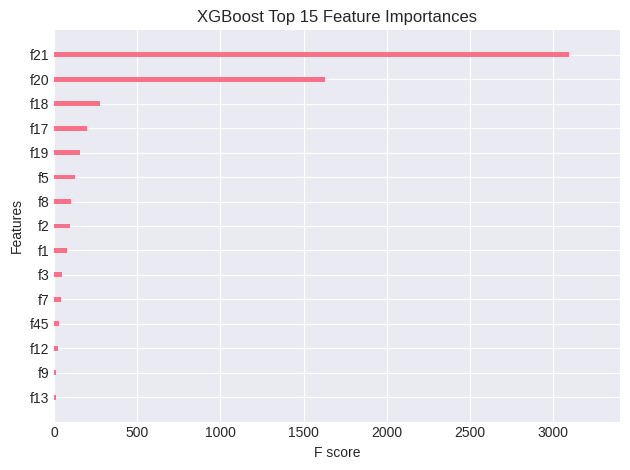


PERFORMANCE (final refit):
Train - RMSE: 0.0541, MAE: 0.0156, R²: 0.9995
Test  - RMSE: 0.1935, MAE: 0.0291, R²: 0.9947


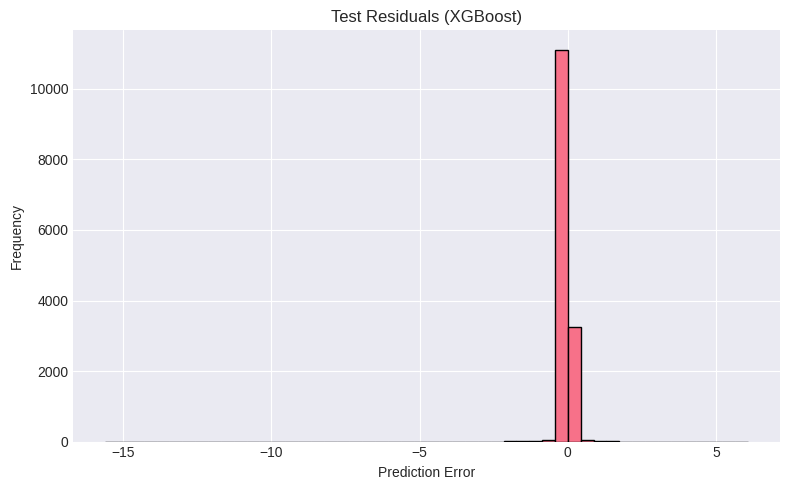


MODEL ATTEMPT 2: XGBoost pipeline completed and model saved.


In [14]:
print("\n" + "="*70)
print("MODEL ATTEMPT 2: XGBoost Regression (Randomized Search, Early Stopping, Interruptible)")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

# 1. Randomized search for efficiency and broader search space
xgb_base = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse',
    tree_method='hist',  # Faster on large data
    verbosity=0
)

xgb_param_dist = {
    'n_estimators': [600, 800],
    'learning_rate': [0.01, 0.05],
    'max_depth': [7, 8],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.2],
    'min_child_weight': [1, 2]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

search_xgb = RandomizedSearchCV(
    xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=25,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    verbose=2, # show progress
    n_jobs=-1,
    random_state=42
)

fit_params = {
    "eval_set": [(X_val, y_val)],
    "verbose": True
}

print("RandomizedSearchCV: Searching XGBoost hyperparameters (interruptible, with early stopping)...")
start_time = datetime.now()
try:
    search_xgb.fit(X_tr, y_tr, **fit_params)
except KeyboardInterrupt:
    print("RandomizedSearchCV interrupted by user. Returning the best model found so far.")
training_time_grid = datetime.now() - start_time
print(f"Randomized search time: {training_time_grid}")

if hasattr(search_xgb, "best_params_"):
    print(f"Best params: {search_xgb.best_params_}")
    print(f"Best CV score (neg_RMSE): {search_xgb.best_score_:.6f}")
    xgb_model = search_xgb.best_estimator_
else:
    print("No best model found. Using default XGBRegressor.")
    xgb_model = xgb_base

# Use early stopping best_iteration if available
best_iter_xgb = getattr(xgb_model, "best_iteration", None)
if best_iter_xgb is None:
    best_iter_xgb = getattr(xgb_model, "best_iteration_", None)
if best_iter_xgb and best_iter_xgb > 0:
    xgb_model.set_params(n_estimators=best_iter_xgb)

print("Fitting XGBoost on train+val set with early stopping...")
start_time = datetime.now()
X_tr_full = np.vstack([X_tr.to_numpy(), X_val.to_numpy()])
y_tr_full = np.concatenate([y_tr.to_numpy(), y_val.to_numpy()])

xgb_model.fit(
    X_tr_full, y_tr_full,
    eval_set=[(X_tr_full, y_tr_full)],
    verbose=False
)
training_time_final = datetime.now() - start_time
print(f"Final fit time: {training_time_final}")

# 3. Feature importance plot
plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=15, importance_type='gain', show_values=False)
plt.title("XGBoost Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# 4. Metrics and additional diagnostics
y_pred_train_att2 = xgb_model.predict(X_tr_full)
y_pred_test_att2 = xgb_model.predict(X_te)

rmse_train_att2 = np.sqrt(mean_squared_error(y_tr_full, y_pred_train_att2))
rmse_test_att2 = np.sqrt(mean_squared_error(y_te, y_pred_test_att2))
mae_train_att2 = mean_absolute_error(y_tr_full, y_pred_train_att2)
mae_test_att2 = mean_absolute_error(y_te, y_pred_test_att2)
r2_train_att2 = r2_score(y_tr_full, y_pred_train_att2)
r2_test_att2 = r2_score(y_te, y_pred_test_att2)

print(f"\nPERFORMANCE (final refit):")
print(f"Train - RMSE: {rmse_train_att2:.4f}, MAE: {mae_train_att2:.4f}, R²: {r2_train_att2:.4f}")
print(f"Test  - RMSE: {rmse_test_att2:.4f}, MAE: {mae_test_att2:.4f}, R²: {r2_test_att2:.4f}")

# 5. Additional error analysis - residuals plot
plt.figure(figsize=(8,5))
plt.hist(y_pred_test_att2 - y_te, bins=50, edgecolor='k')
plt.title("Test Residuals (XGBoost)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

joblib.dump(xgb_model, OUTPUT_PATH / 'model_attempt2_xgb.pkl')

print("\nMODEL ATTEMPT 2: XGBoost pipeline completed and model saved.")

In [ ]:
y_pred_val_xgb = xgb_model.predict(X_val)


# ## 7. Попытка 3: Ансамбль моделей (взвешенное усреднение)

так как у меня некоторые логи не сохранились, но я сохранил модели, то мы можем еще раз протестировать отдельно качество каждой и уже потом построить из них ансамбль

In [ ]:
import joblib

# Загрузка модели LightGBM (GPU) из файла
model_lgb_gpu = joblib.load('models/model_lgb_gpu.pkl')

# Предсказания для трейна и теста
y_pred_train_lgb_gpu = model_lgb_gpu.predict(X_tr_full)
y_pred_test_lgb_gpu = model_lgb_gpu.predict(X_te)


# Подсчет метрик
rmse_train_lgb_gpu = np.sqrt(mean_squared_error(y_tr_full, y_pred_train_lgb_gpu))
rmse_test_lgb_gpu = np.sqrt(mean_squared_error(y_te, y_pred_test_lgb_gpu))
mae_train_lgb_gpu = mean_absolute_error(y_tr_full, y_pred_train_lgb_gpu)
mae_test_lgb_gpu = mean_absolute_error(y_te, y_pred_test_lgb_gpu)
r2_train_lgb_gpu = r2_score(y_tr_full, y_pred_train_lgb_gpu)
r2_test_lgb_gpu = r2_score(y_te, y_pred_test_lgb_gpu)

print(f"\nPERFORMANCE (LightGBM GPU loaded):")
print(f"Train - RMSE: {rmse_train_lgb_gpu:.4f}, MAE: {mae_train_lgb_gpu:.4f}, R²: {r2_train_lgb_gpu:.4f}")
print(f"Test  - RMSE: {rmse_test_lgb_gpu:.4f}, MAE: {mae_test_lgb_gpu:.4f}, R²: {r2_test_lgb_gpu:.4f}")


PERFORMANCE (LightGBM GPU loaded):
Train - RMSE: 0.0500, MAE: 0.0136, R²: 0.9996
Test  - RMSE: 0.1087, MAE: 0.0203, R²: 0.9983


In [ ]:
y_pred_val_lgb_gpu = model_lgb_gpu.predict(X_val)

In [16]:
print("\n" + "="*70)
print("MODEL ATTEMPT 3: Ensemble (Weighted Averaging)")
print("="*70)

# Combine predictions from both models with weights
# Weights based on validation performance

# Calculate weights inversely proportional to error
weight_lgb = 1 / rmse_train_lgb_gpu
weight_xgb = 1 / rmse_test_att2
total_weight = weight_lgb + weight_xgb
weight_lgb_norm = weight_lgb / total_weight
weight_xgb_norm = weight_xgb / total_weight

print(f"\nWeights:")
print(f"  LightGBM: {weight_lgb_norm:.4f}")
print(f"  XGBoost:  {weight_xgb_norm:.4f}")

# Ensemble predictions
y_pred_train_att3 = weight_lgb_norm * y_pred_train_lgb_gpu + weight_xgb_norm * y_pred_train_att2
y_pred_test_att3 = weight_lgb_norm * y_pred_test_lgb_gpu + weight_xgb_norm * y_pred_test_att2

# Metrics
rmse_train_att3 = np.sqrt(mean_squared_error(y_tr_full, y_pred_train_att3))
rmse_test_att3 = np.sqrt(mean_squared_error(y_te, y_pred_test_att3))
mae_train_att3 = mean_absolute_error(y_tr_full, y_pred_train_att3)
mae_test_att3 = mean_absolute_error(y_te, y_pred_test_att3)
r2_train_att3 = r2_score(y_tr_full, y_pred_train_att3)
r2_test_att3 = r2_score(y_te, y_pred_test_att3)

print(f"\nPERFORMANCE:")
print(f"Train - RMSE: {rmse_train_att3:.4f}, MAE: {mae_train_att3:.4f}, R²: {r2_train_att3:.4f}")
print(f"Test  - RMSE: {rmse_test_att3:.4f}, MAE: {mae_test_att3:.4f}, R²: {r2_test_att3:.4f}")


MODEL ATTEMPT 3: Ensemble (Weighted Averaging)

Weights:
  LightGBM: 0.7946
  XGBoost:  0.2054

PERFORMANCE:
Train - RMSE: 0.0444, MAE: 0.0120, R²: 0.9997
Test  - RMSE: 0.1148, MAE: 0.0189, R²: 0.9981


In [37]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("\n" + "="*70)
print("MODEL ATTEMPT 3: VotingRegressor (Weighted)")
print("="*70)

# веса: чем меньше RMSE, тем больше вес (как у тебя)
w_lgb = 0.61594702
w_xgb = 0.38405298
w_sum = w_lgb + w_xgb
w_lgb_norm, w_xgb_norm = w_lgb / w_sum, w_xgb / w_sum

print(f"\nWeights:")
print(f"  LightGBM: {w_lgb_norm:.4f}")
print(f"  XGBoost:  {w_xgb_norm:.4f}")

# ВАЖНО: estimators должны быть sklearn-совместимыми моделями с fit/predict
# Предполагаю, что у тебя уже есть объекты lgb_model и xgb_model
voting = VotingRegressor(
    estimators=[
        ("lgb", model_lgb_gpu),
        ("xgb", xgb_model),
    ],
    weights=[w_lgb_norm, w_xgb_norm]
)  # VotingRegressor усредняет предсказания моделей [web:1]

# Fit на train
voting.fit(X_tr_full, y_tr_full)  # VotingRegressor обучает каждый estimator на всём train [web:1]

# Predict
y_pred_train_att3 = voting.predict(X_tr_full)  # predict = среднее (взвешенное) предсказаний [web:1]
y_pred_test_att3  = voting.predict(X_te)

# Metrics
rmse_train_att3 = np.sqrt(mean_squared_error(y_tr_full, y_pred_train_att3))
rmse_test_att3  = np.sqrt(mean_squared_error(y_te, y_pred_test_att3))
mae_train_att3  = mean_absolute_error(y_tr_full, y_pred_train_att3)
mae_test_att3   = mean_absolute_error(y_te, y_pred_test_att3)
r2_train_att3   = r2_score(y_tr_full, y_pred_train_att3)
r2_test_att3    = r2_score(y_te, y_pred_test_att3)

print(f"\nPERFORMANCE:")
print(f"Train - RMSE: {rmse_train_att3:.4f}, MAE: {mae_train_att3:.4f}, R²: {r2_train_att3:.4f}")
print(f"Test  - RMSE: {rmse_test_att3:.4f}, MAE: {mae_test_att3:.4f}, R²: {r2_test_att3:.4f}")



MODEL ATTEMPT 3: VotingRegressor (Weighted)

Weights:
  LightGBM: 0.6159
  XGBoost:  0.3841

PERFORMANCE:
Train - RMSE: 0.0421, MAE: 0.0115, R²: 0.9997
Test  - RMSE: 0.1268, MAE: 0.0192, R²: 0.9977


In [44]:
X_te

,sell_price,sales_lag_7,sales_lag_14,sales_lag_30,sales_lag_90,sales_mean_7,sales_std_7,sales_min_7,sales_max_7,sales_mean_14,...,item_std_sales,store_avg_sales,store_std_sales,cat_avg_sales,cat_std_sales,dept_avg_sales,dept_std_sales,store_cat_avg_sales,price_sales_interaction,store_item_interaction
1912,0.98,0.0,4.0,5.0,1.0,2.571429,1.718249,0.0,5.0,2.071429,...,1.284363,0.994683,2.516381,1.291407,3.171171,0.522737,1.158047,1.449124,0.00,0.677061
1913,0.98,0.0,1.0,3.0,0.0,3.000000,1.290994,1.0,5.0,2.214286,...,1.284363,0.994683,2.516381,1.291407,3.171171,0.522737,1.158047,1.449124,0.00,0.677061
1914,0.98,1.0,2.0,0.0,0.0,3.000000,1.290994,1.0,5.0,2.142857,...,1.284363,0.994683,2.516381,1.291407,3.171171,0.522737,1.158047,1.449124,0.98,0.677061
1915,0.98,5.0,1.0,1.0,0.0,2.428571,1.133893,1.0,4.0,2.142857,...,1.284363,0.994683,2.516381,1.291407,3.171171,0.522737,1.158047,1.449124,4.90,0.677061
1916,0.98,2.0,1.0,1.0,1.0,2.142857,1.463850,0.0,4.0,2.071429,...,1.284363,0.994683,2.516381,1.291407,3.171171,0.522737,1.158047,1.449124,1.96,0.677061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970495,2.96,0.0,0.0,1.0,0.0,0.428571,1.133893,0.0,3.0,0.428571,...,0.597263,0.892756,2.676928,0.666187,1.736108,0.243921,0.713082,0.537162,0.00,0.136742
970496,2.96,0.0,0.0,3.0,1.0,0.714286,1.253566,0.0,3.0,0.571429,...,0.597263,0.892756,2.676928,0.666187,1.736108,0.243921,0.713082,0.537162,0.00,0.136742
970497,2.96,0.0,0.0,0.0,0.0,0.714286,1.253566,0.0,3.0,0.571429,...,0.597263,0.892756,2.676928,0.666187,1.736108,0.243921,0.713082,0.537162,0.00,0.136742
970498,2.96,0.0,2.0,1.0,1.0,1.142857,1.463850,0.0,3.0,0.642857,...,0.597263,0.892756,2.676928,0.666187,1.736108,0.243921,0.713082,0.537162,0.00,0.136742


In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

# OOF/valid предсказания базовых моделей (важно: не train, чтобы не переобучиться)
P = np.vstack([y_pred_val_lgb_gpu, y_pred_val_xgb]).T   # shape: (n, 2)
y = y_val

def objective(w):
    y_hat = P @ w
    return mean_squared_error(y, y_hat)  # MSE; RMSE даст тот же argmin [web:22]

cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0})
bounds = [(0.0, 1.0)] * P.shape[1]
w0 = np.ones(P.shape[1]) / P.shape[1]

res = minimize(objective, w0, method="SLSQP", bounds=bounds, constraints=cons)  # SLSQP часто используют для таких весов [web:29]
w_opt = res.x
print("Optimal weights:", w_opt, "MSE:", res.fun)


Optimal weights: [0.5 0.5] MSE: 0.0013867131405662428


In [36]:
from sklearn.linear_model import LinearRegression
import numpy as np

X_blend = np.vstack([y_pred_val_lgb_gpu, y_pred_val_xgb]).T
reg = LinearRegression(positive=True)
reg.fit(X_blend, y_val)  # обучает веса, минимизируя RSS (=> MSE) [web:37][web:27]

w = reg.coef_
w = w / w.sum()            # если хочешь именно convex weights sum=1
b = reg.intercept_
print("weights:", w, "intercept:", b)

weights: [0.61594702 0.38405298] intercept: -0.00025624112487010464


## 8. Results Comparison and Best Model Selection

In [38]:
# Create comparison table
results_comparison = pd.DataFrame({
    'Attempt': ['1: LightGBM', '2: XGBoost', '3: Ensemble'],
    'Train RMSE': [rmse_train_lgb_gpu, rmse_train_att2, rmse_train_att3],
    'Test RMSE': [rmse_test_lgb_gpu, rmse_test_att2, rmse_test_att3],
    'Train MAE': [mae_train_lgb_gpu, mae_train_att2, mae_train_att3],
    'Test MAE': [mae_test_lgb_gpu, mae_test_att2, mae_test_att3],
    'Train R²': [r2_train_lgb_gpu, r2_train_att2, r2_train_att3],
    'Test R²': [r2_test_lgb_gpu, r2_test_att2, r2_test_att3]
})

print("\n" + "="*100)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*100)
print(results_comparison.to_string(index=False))

# Select best model based on test RMSE
best_test_rmse = results_comparison['Test RMSE'].min()
best_attempt_idx = results_comparison['Test RMSE'].idxmin()
best_attempt_name = results_comparison.loc[best_attempt_idx, 'Attempt']

print(f"\n" + "="*100)
print(f"BEST MODEL: {best_attempt_name}")
print(f"Test RMSE: {best_test_rmse:.4f}")
print("="*100)


COMPREHENSIVE RESULTS COMPARISON
    Attempt  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²
1: LightGBM    0.050000   0.108731   0.013616  0.020344  0.999597 0.998335
 2: XGBoost    0.054122   0.193450   0.015604  0.029134  0.999527 0.994730
3: Ensemble    0.042105   0.126789   0.011485  0.019210  0.999714 0.997736

BEST MODEL: 1: LightGBM
Test RMSE: 0.1087


## 9. Comparison with LAMA Baseline

In [43]:
automl_loaded_default = joblib.load('lama_automl.joblib')
y_pred_train_loaded1 = automl_loaded_default.predict(X_tr).data.ravel()
y_pred_test_loaded1 = automl_loaded_default.predict(X_te).data.ravel()

print("TEST SET:")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_te, y_pred_test_loaded1)):.4f}")
print(f"  MAE:  {mean_absolute_error(y_te, y_pred_test_loaded1):.4f}")
print(f"  R2:   {r2_score(y_te, y_pred_test_loaded1):.4f}")

TEST SET:
  RMSE: 0.0425
  MAE:  0.0140
  R2:   0.9997


In [42]:
# Reference LAMA baseline (from Part 2 notebook)
lama_baseline_rmse = np.sqrt(mean_squared_error(y_te, automl_loaded_default.predict(X_te).data.ravel()))  # Evaluate on test set

print("\n" + "="*70)
print("COMPARISON WITH LAMA BASELINE")
print("="*70)

print(f"\nCustom Best Model Test RMSE: {best_test_rmse:.4f}")
print(f"LAMA Baseline Test RMSE: {lama_baseline_rmse:.4f}")

if best_test_rmse < lama_baseline_rmse:
    print(f"\n✓ Custom solution improves over LAMA baseline!")
else:
    print(f"\nNote: LAMA baseline is still better; further optimization needed.")



COMPARISON WITH LAMA BASELINE

Custom Best Model Test RMSE: 0.1087
LAMA Baseline Test RMSE: 0.0425

Note: LAMA baseline is still better; further optimization needed.


## 10. Feature Importance Analysis